Per prima cosa importo il dataset, lo trasformo in un **`DataFrame Pandas`** e inizio a visualizzarlo

In [1]:
# importo il dataset dalla libreria
from sklearn.datasets import load_wine

# importo pandas per operare sul dataset
import pandas as pd

# carico il dataset sottoforma di variabile
wine = load_wine()

# dalla variabile appena creata costruisco il mio dataframe con i suoi attributi
df = pd.DataFrame(wine.data, columns=wine.feature_names)

# aggiungo al dataframe la colonna target (y) sfruttando l'attributo ".target"
df["target"] = wine.target

# visualizzo le prime righe
df.head()    

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Per completezza visualizzo le informazioni sul dataset grazie alla libreria **`Scikit learn`**

In [2]:
# sempre sfruttando un attributo della variabile visualizzo una sua descrizione
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

Che cosa posso dire leggendo queste informazioni?
+ il dataset è composto da 178 campioni
+ possiede 13 features numeriche
+ ogni campione può ricadere in 3 classi: 0,1 e 2

Un'altra caratteristica importante per successive valutazioni è quella di verificare la distribuzione delle classi:

In [3]:
from collections import Counter
X = wine.data #features
y = wine.target #target
# Conta le occorrenze delle classi
class_counts = Counter(y)
print("Distribuzione delle classi:", class_counts)

Distribuzione delle classi: Counter({np.int64(1): 71, np.int64(0): 59, np.int64(2): 48})


Osservando i risultati ne emerge che le classi non sono perfettamente bilanciate, sarà dunque opportuno escludere criteri di valutazione come accuracy e privilegiare F1_score nella scelta del modello

Successivamente procedo a visualizzare il range numerico di tutte le features:

C:\Users\MM\AppData\Local\Temp\ipykernel_12220\2595909606.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_ranges.values, y=sorted_ranges.index, palette="viridis")


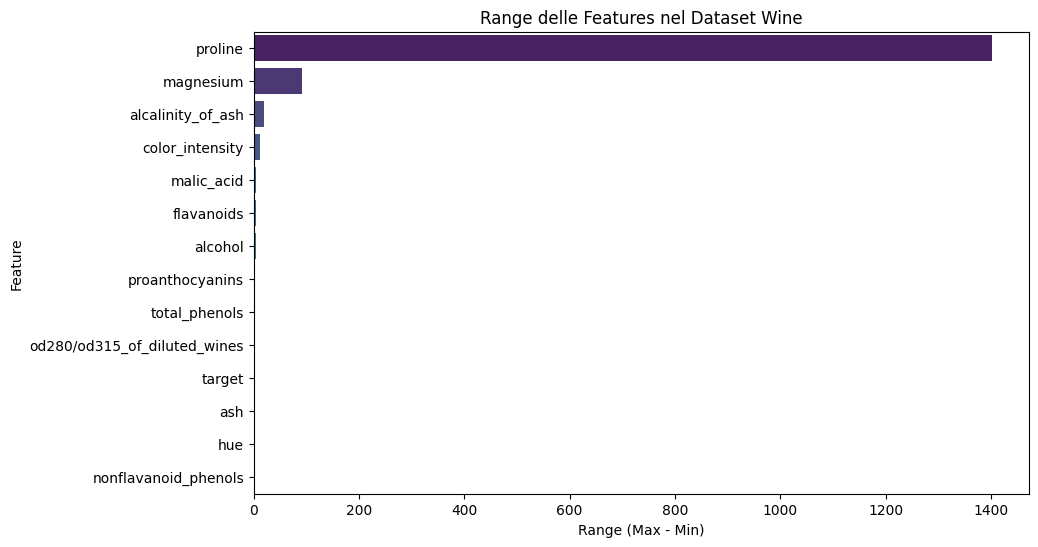

In [5]:
# importo la libreria d'interesse
import seaborn as sns
import matplotlib.pyplot as plt
df_range = df.max() - df.min()

# Ordina le feature in base al range
sorted_ranges = df_range.sort_values(ascending=False)

# Crea il grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_ranges.values, y=sorted_ranges.index, palette="viridis")
plt.xlabel("Range (Max - Min)")
plt.ylabel("Feature")
plt.title("Range delle Features nel Dataset Wine")
plt.show()

Ne emerge che la feature "proline" possiede un range di valori molto più ampio rispetto alle altre, tuttavia decido di mantenere lo scaling di questa feature per osservarne gli effetti predittivi dei modelli

Un altro topic interessante è quello di rilevare le features che denotano maggior discostamento nella distribuzione tra le classi

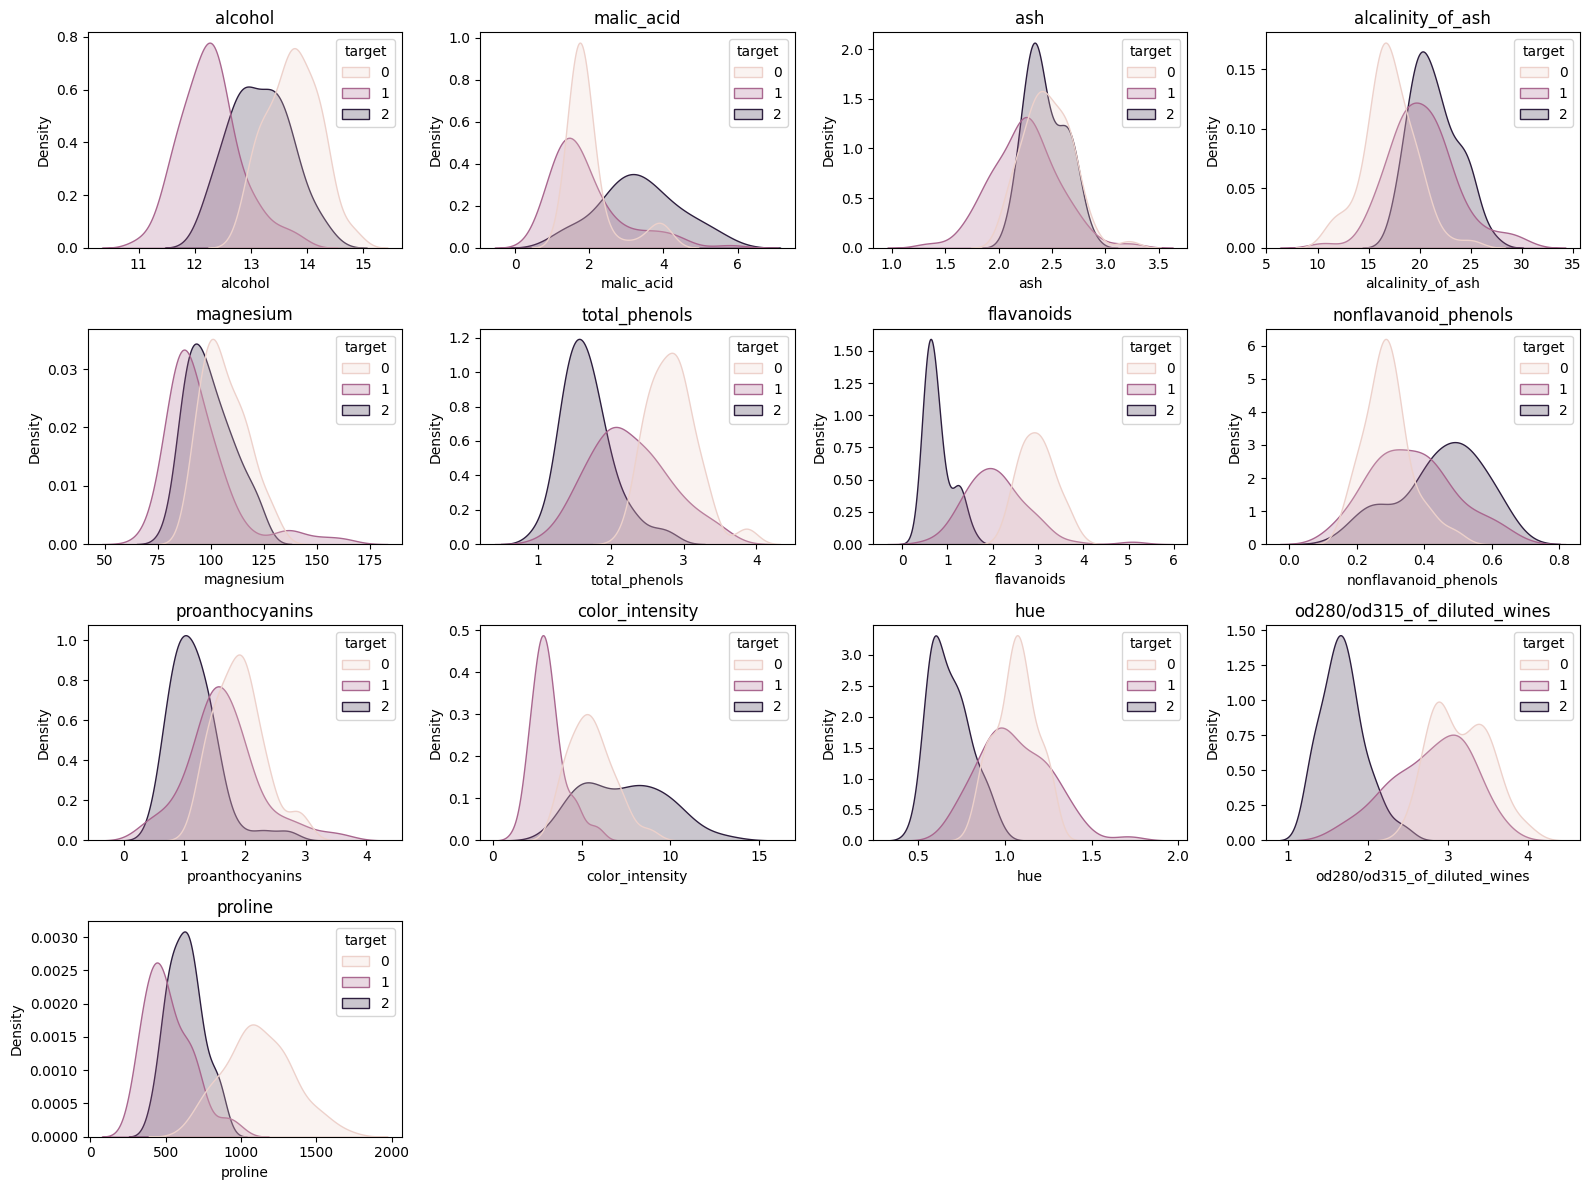

In [6]:
# calcolo il numero di righe necessarie (figure)
num_features = len(df.columns) - 1  # escludo 'target'
num_rows = (num_features // 4) + (num_features % 4 > 0)  

# imposto la figura con subplot adeguati
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 3 * num_rows))
axes = axes.flatten()  # rende gli assi iterabili

# plotto KDE per ogni feature
for i, feature in enumerate(df.columns[:-1]):  # escludo 'target'
    sns.kdeplot(data=df, x=feature, hue="target", fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(feature)

# elimino gli assi inutilizzati
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# miglioro il layout
plt.tight_layout()
plt.show()

Tra le features che presentano una maggiore differenza nella distribuzione fra classi troviamo:
+ flavanoids
+ color_intensity
+ proline

Questro risultato (anche se sarà valutato dal modello) serve semplicemente a dirci quali delle features saranno più determinanti nel suddividere i campioni nelle varie classi

La strategia che andrò ad applicare è il **baseline model**: seleziono un modello semplice insieme ad altri più complessi, di tutti questi modelli andrò a calcolare con l'**F1_score**, un punteggio di "prestazione". Se almeno un modello complesso avrà battuto il baseline model significa che aggiungere complessità porterà a migliori capacità predittive, al contrario il modello semplice sarà in grado di garantirci una classificazione dei campioni più accurata.

In [7]:
# Importo le librerie necessarie
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB  # Modello baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.datasets import load_wine

# Divido il dataset in training e test set (senza scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definizione del modello baseline (semplice)
baseline_model = GaussianNB()

# Valutazione del modello baseline con Cross-Validation (F1-score)
baseline_score = np.mean(cross_val_score(baseline_model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')))
print(f"Baseline Model (Naive Bayes) - F1 Score: {baseline_score:.4f}")

# Definizione di modelli più complessi (senza scaling)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42)
}

# Valutazione dei modelli con F1-score e confronto con il baseline
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted'))
    results[name] = np.mean(scores)

# Stampa dei risultati
print("\nRisultati dei modelli (F1 Score medio):")
for model, score in results.items():
    print(f"{model}: {score:.4f}")

# Confronto con il baseline
best_model = max(results, key=results.get)
print(f"\nMiglior modello: {best_model} con F1 Score medio di {results[best_model]:.4f}")

if results[best_model] > baseline_score:
    print(f"Il miglior modello ({best_model}) ha superato il baseline model di {results[best_model] - baseline_score:.4f}")
else:
    print(f"Il modello baseline è ancora il migliore!")

Baseline Model (Naive Bayes) - F1 Score: 0.9720

Risultati dei modelli (F1 Score medio):
Random Forest: 0.9860
K-Nearest Neighbors: 0.7032
Support Vector Machine: 0.9581
Logistic Regression: 0.9721

Miglior modello: Random Forest con F1 Score medio di 0.9860
Il miglior modello (Random Forest) ha superato il baseline model di 0.0139


Dalle analisi emerge che il modello **`Random Forest`** ha accumulato il punteggio più alto di accuratezza. Ora vorrei ottimizzare i suoi iperparametri per massimizzare le sue prestazioni.

Ho scelto **`max_depth`** e **`n_estimators`** come iperparametri da validare per il modello **Random Forest** perché:  

### `n_estimators` (Numero di alberi) 
- Controlla **quanti alberi** compongono la foresta.  
- Un numero maggiore tende a migliorare la performance riducendo la varianza, ma aumenta il tempo di addestramento.  
- Un valore troppo basso può portare a **overfitting** o **underfitting**.  

### `max_depth` (Profondità massima degli alberi)   
- Controlla quanto in **profondità** gli alberi possono crescere.  
- Se è troppo grande, gli alberi **memorizzano troppo i dati di training** (overfitting).  
- Se è troppo piccolo, il modello **non cattura abbastanza pattern** (underfitting).  

Per testare il numero idoneo di **`n_estimators`** e **`max_depth`** utilizzo la grid_search. Si tratta di un potente metodo di cross-validation che permette di testare ogni possibile combinazione di valori degli iperparametri usando una tecnica di cv, selezionandone i migliori sulla base della performance media.

Ho scelto questi valori per `n_estimators` e `max_depth` basandomi su considerazioni pratiche e sul bilanciamento tra performance e costo computazionale:

### `n_estimators`: [10, 50, 100, 200]   
- **10** → Un valore basso per testare se pochi alberi sono sufficienti.  
- **50** → Un valore intermedio che spesso fornisce buone prestazioni senza essere troppo costoso.  
- **100** → Un valore comunemente usato come default in molti problemi di classificazione.  
- **200** → Un numero elevato per verificare se più alberi migliorano ulteriormente le performance.  

🔹 **Motivazione**: Aumentare `n_estimators` riduce la varianza, ma oltre un certo punto i miglioramenti diventano marginali e il tempo di addestramento cresce inutilmente.  


### `max_depth`: [None, 5, 10, 20]   
- **None** → Permette agli alberi di crescere fino a quando tutte le foglie contengono meno di `min_samples_split`.  
- **5** → Un valore basso per testare se un modello semplice è sufficiente.  
- **10** → Un compromesso tra semplicità e capacità di apprendimento.  
- **20** → Un valore alto per testare se una maggiore profondità migliora la classificazione.  

🔹 **Motivazione**:  
- Un valore troppo basso potrebbe portare a **underfitting** (non apprende abbastanza dai dati).  
- Un valore troppo alto potrebbe causare **overfitting** (modello troppo complesso che memorizza i dati di training).  


In questo caso la metrica di validazione che ho scelto è la **`F1-score`**. Questa metrica bilancia **precision** e **recall**, quindi è utile quando vogliamo penalizzare sia i falsi positivi che i falsi negativi.

In [ ]:
# importo le librerie da utilizzare
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

# definisco il modello Random Forest
rf = RandomForestClassifier(random_state=42)

# suddivido il dataset in Train (80%) e Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definisco la griglia di iperparametri
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20]
}

# definisco la strategia K-Fold (per la validazione incrociata)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# uso F1-score come metrica di valutazione
f1_scorer = make_scorer(f1_score, average='weighted')

# creo la GridSearchCV con F1-score come scoring
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring=f1_scorer, n_jobs=-1)

# eseguo la ricerca della migliore configurazione
grid_search.fit(X_train, y_train)

# stampo i migliori parametri trovati
print("Migliori iperparametri:", grid_search.best_params_)
print("Migliore F1-score:", grid_search.best_score_)

Migliori iperparametri: {'max_depth': None, 'n_estimators': 100}
Migliore F1-score: 0.9793170510243364


Una volta che ho determinato gli iperparametri migliori per il mio modello, voglio testare la sua effettiva efficacia con il metodo **`ROC-AUC`**:

ROC-AUC Score (One-vs-Rest): 1.0000


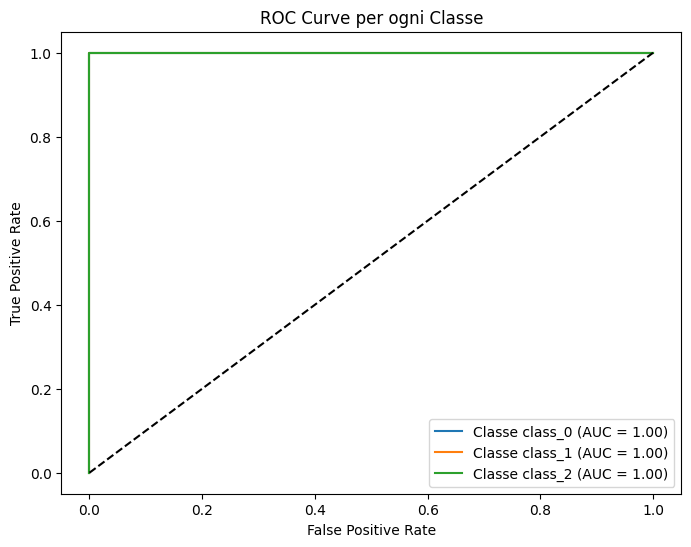

In [ ]:
#importo dalle librerie le funzioni d'interesse
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# grazie a questa funzione trasformo le classi in una matrice binaria (0 e 1), ogni riga rappresenta un campione, dove la posizione dell'1 determinerà in quale classe
# (in quale delle tre colonne) ricadrà il campione
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
# questa funzione (y_pred_proba) ci restituisce una matrice, anche qui ogni riga rappresenta un campione, e ogni valore incolonnato rappresenterà la probabilità (da 0 a 1) che avrà il campione 
# di ricadere in quella classe (ogni posizione rappresenta una classe)
best_model = grid_search.best_estimator_ # miglior modello selezionato dalla gridsearch
y_pred_proba = best_model.predict_proba(X_test)

# calcolo dell'AUC-ROC utilizzando il metodo One-vs-Rest, ovvero a turno una classe viene considerata positiva mentre le altre negative
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
# viene stampato il risultato con 4 cifre decimali
print(f"ROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")

# imposto le dimensioni della figura su cui si svilupperà il grafico ROC AUC
plt.figure(figsize=(8,6))
# ciclo per ogni classe
for i in range(y_test_bin.shape[1]):
    # selezionando le colonne delle matrici prima create estrapolo FPR (False Positive Rate) e TPR (True Positive Rate): percentuale di veri positivi, inoltre la funzione calcola anche 
    # la soglie di decisione usate per calcolare FPR e TPR, ma in questo caso verranno ignorate
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    # posiziono fpr e tpr rispettivamente nelle ascisse e nelle ordinate, imposto nella legenda il nome delle classi e il valore dell'AUC calcolato
    plt.plot(fpr, tpr, label=f'Classe {wine.target_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale (random guess)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per ogni Classe")
plt.legend()
plt.show()

Dai risultati emersi, si osserva che il modello ha saputo separare le classi correttamente in tutti i campioni del test-set (AUC = 1.00)